3 iterasi, akurasi terbaik

# Cell 1: Import Libraries and Setup Device
"""
This cell imports all the necessary libraries and sets up the device for GPU computation if available.
We are using PyTorch for deep learning, OpenCV for image processing, and Matplotlib/Seaborn for visualization.
"""

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
import cv2
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from tqdm import tqdm
import os
import numpy as np
import time
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Cek apakah kode dijalankan di Google Colab
IN_COLAB = 'google.colab' in str(get_ipython())

# Cek apakah GPU tersedia, jika tidak gunakan CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Mount Google Drive jika menggunakan Google Colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')


Using device: cuda
Mounted at /content/drive


# Cell 2: Define Data Loading and Preprocessing Functions
"""
This cell contains functions to load and preprocess images from the dataset.
The `load_data` function loads images from the specified directory and assigns labels based on the folder structure.
The `preprocess_image` function applies CLAHE and unsharp masking to enhance image quality.
The `CustomDataset` class integrates these functions and prepares the dataset for use in PyTorch.
"""

In [ ]:
def load_data(dataset_path, subset):
    images = []
    labels = []

    # Tentukan label sesuai dengan subset

    label_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']



    # Pemetaan nama label ke indeks
    label_map = {name: idx for idx, name in enumerate(label_names)}

    subset_path = os.path.join(dataset_path, subset)
    for label_name in label_names:
        image_dir = os.path.join(subset_path, label_name)
        if not os.path.exists(image_dir):
            raise FileNotFoundError(f"Directory not found: {image_dir}")
        for file_name in os.listdir(image_dir):
            if file_name.endswith('.png'):  # Cek jika file adalah gambar PNG
                image_path = os.path.join(image_dir, file_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Unable to load image {image_path}")
                    continue
                images.append(image)
                labels.append(label_map[label_name])
                print(f"Loaded image {image_path}")
    return images, labels

def preprocess_image(image):
    if image is None or image.size == 0:
        raise ValueError("Empty image provided for preprocessing")

    # Terapkan CLAHE untuk meningkatkan kontras
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(10, 10))

    clahe_image = clahe.apply(image)

    # Terapkan Gaussian Blur untuk menghaluskan gambar
    #gaussian = cv2.GaussianBlur(image, (9, 9), 10.0)
    # Terapkan Unsharp Masking untuk meningkatkan ketajaman gambar
    #unsharp_image = cv2.addWeighted(clahe_image, 1.5, gaussian, -0.5, 0, clahe_image)
    #unsharp_image = cv2.addWeighted(gaussian, 1.5, gaussian, -0.5, 0)

    return clahe_image

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        try:
            # Proses gambar
            image = preprocess_image(image)
        except ValueError as e:
            print(f"Error preprocessing image at index {idx}: {e}")
            plt.imshow(image, cmap='gray')
            plt.title(f"Label: {label}")
            plt.show()
            raise e
        # Terapkan transformasi jika ada
        if self.transform:
            image = self.transform(image)
        if image.dim() == 2:  # Pastikan gambar memiliki 3 dimensi
            image = image.unsqueeze(0)
        return image, label


# Cell 3: Load and Transform Data
"""
This cell loads the data and applies the necessary transformations.
The dataset is divided into training, validation, and test sets.
Each image is transformed into a 224x224 size tensor suitable for input to the VGG-16 model.
"""

In [ ]:
# Mengatur path dataset, disesuaikan untuk Google Colab atau Jupyter Notebook
dataset_path = '/content/drive/MyDrive/Chest-CT-Data'

# Load data
train_images, train_labels = load_data(dataset_path, 'train')
valid_images, valid_labels = load_data(dataset_path, 'valid')
test_images, test_labels = load_data(dataset_path, 'test')

print(f"Loaded {len(train_images)} training images with {len(train_labels)} labels")
print(f"Loaded {len(valid_images)} validation images with {len(valid_labels)} labels")
print(f"Loaded {len(test_images)} test images with {len(test_labels)} labels")

# Transformasi data untuk persiapan training, validation, dan testing
transform = transforms.Compose([
    transforms.ToPILImage(),             # Ubah dari array NumPy ke gambar PIL
    transforms.Resize((224, 224)),       # Ubah ukuran gambar menjadi 224x224
    #v2.RandomHorizontalFlip(),           # Randomly flip the image horizontally
   # v2.RandomRotation(15),                # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),               # Ubah gambar menjadi Tensor and normalize to [0, 1]
])

# Membuat dataset dan data loader untuk training, validation, dan testing
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
valid_dataset = CustomDataset(valid_images, valid_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # DataLoader untuk training
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False) # DataLoader untuk validasi
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)   # DataLoader untuk testing


Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/ad12.png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000104 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000118 (4).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/ad21.png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000107 (9).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000102 (7).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000097 (2).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000106 (10).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000101 (7).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/000105 (4).png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/ad2.png
Loaded image /content/drive/MyDrive/Chest-CT-Data/train/adenocarcinoma/

## Pruning

In [ ]:
import torch
import torch.nn as nn

# Fungsi untuk pruning layer Conv2D berdasarkan L2 norm
def l2_prune_conv2d_layer(module, pruning_amount):
    with torch.no_grad():
        weight = module.weight.data.view(module.weight.size(0), -1)
        l2_norms = torch.norm(weight, p=2, dim=1)

    num_filters = module.weight.size(0)
    num_prune = int(pruning_amount * num_filters)

    if num_prune == 0:
        return module, module.out_channels  # Tidak ada pruning jika num_prune adalah 0

    prune_indices = torch.argsort(l2_norms)[:num_prune]
    keep_indices = torch.argsort(l2_norms)[num_prune:]

    # Membentuk ulang layer Conv2D dengan filter yang dipertahankan
    new_conv = nn.Conv2d(
        in_channels=module.in_channels,
        out_channels=num_filters - num_prune,
        kernel_size=module.kernel_size,
        stride=module.stride,
        padding=module.padding,
        bias=module.bias is not None
    )

    new_conv.weight.data = module.weight.data[keep_indices].clone()
    if module.bias is not None:
        new_conv.bias.data = module.bias.data[keep_indices].clone()

    return new_conv, new_conv.out_channels

# Fungsi untuk mengganti layer secara rekursif dalam model
def replace_layers(module, pruning_amount=0.5):
    prev_out_channels = None

    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d):
            # Prune the Conv2D layer and replace it
            pruned_layer, new_out_channels = l2_prune_conv2d_layer(child, pruning_amount)

            # Jika ada layer sebelumnya, sesuaikan in_channels dari layer saat ini
            if prev_out_channels is not None:
                pruned_layer = nn.Conv2d(
                    in_channels=prev_out_channels,  # Sesuaikan dengan output layer sebelumnya
                    out_channels=new_out_channels,
                    kernel_size=child.kernel_size,
                    stride=child.stride,
                    padding=child.padding,
                    bias=child.bias is not None
                )
                pruned_layer.weight.data = child.weight.data[:new_out_channels, :prev_out_channels].clone()
                if pruned_layer.bias is not None:
                    pruned_layer.bias.data = child.bias.data[:new_out_channels].clone()

            setattr(module, name, pruned_layer)

            # Update jumlah channel output untuk layer berikutnya
            prev_out_channels = new_out_channels

        elif isinstance(child, nn.Sequential) or isinstance(child, nn.Module):
            # Recursive call for nested Sequential or Module
            replace_layers(child, pruning_amount)

# Fungsi untuk menyesuaikan layer klasifikasi (fully connected) dalam model
def adjust_classifier(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Sesuaikan ukuran input jika perlu
        features_output = model.features(dummy_input)
        flattened_size = features_output.view(features_output.size(0), -1).size(1)

    first_linear = None
    for module in model.classifier:
        if isinstance(module, nn.Linear):
            first_linear = module
            break

    if first_linear is not None:
        new_linear = nn.Linear(flattened_size, first_linear.out_features).to(device)
        with torch.no_grad():
            new_linear.weight.data[:, :min(flattened_size, first_linear.in_features)] = \
                first_linear.weight.data[:, :min(flattened_size, first_linear.in_features)]
            new_linear.bias.data = first_linear.bias.data

        for i, module in enumerate(model.classifier):
            if module is first_linear:
                model.classifier[i] = new_linear
                break

        print(f"Adjusted classifier input size to {flattened_size}")
    else:
        print("No Linear layer found in classifier. The model structure might need manual adjustment.")

# Fungsi untuk pruning model yang telah dilatih
def prune_trained_model(model, pruning_amount=0.1):
    replace_layers(model.features, pruning_amount)
    adjust_classifier(model)
    return model

def load_and_prune_model(model_path, model_class, pruning_ratio):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    state_dict = torch.load(model_path)
    model = model_class().to(device)
    model.load_state_dict(state_dict)
    print("Original model loaded.")

    # Prune model
    pruned_model =  prune_trained_model(model, pruning_ratio).to(device)
    print("Model pruned.")
    return pruned_model



def calculate_model_size(model):
    """
    Calculate the size of the model in megabytes (MB).

    Args:
    - model: The model (before or after pruning).

    Returns:
    - size_in_mb: The size of the model in MB.
    """
    param_size = sum(param.numel() * param.element_size() for param in model.parameters())
    buffer_size = sum(buffer.numel() * buffer.element_size() for buffer in model.buffers())
    size_in_bytes = param_size + buffer_size
    size_in_mb = size_in_bytes / 1024**2  # Convert bytes to megabytes (MB)
    return size_in_mb

# Fungsi untuk memverifikasi pruning model
def verify_pruned_model(model, original_model):
    def calculate_num_params(model):
        return sum(p.numel() for p in model.parameters())

    # Calculate the model sizes
    original_size = calculate_model_size(original_model)
    pruned_size = calculate_model_size(model)
    print(f"Original model size: {original_size:.2f} MB")
    print(f"Pruned model size: {pruned_size:.2f} MB")
    print(f"Size reduction: {original_size - pruned_size:.2f} MB ({(original_size - pruned_size) / original_size * 100:.2f}%)")

    original_params = calculate_num_params(original_model)
    pruned_params = calculate_num_params(model)
    print(f"Original model parameters: {original_params}")
    print(f"Pruned model parameters: {pruned_params}")

    print("\nLayer-wise dimension comparison:")
    for (orig_name, orig_module), (pruned_name, pruned_module) in zip(original_model.features.named_modules(), model.features.named_modules()):
        if isinstance(orig_module, nn.Conv2d) and isinstance(pruned_module, nn.Conv2d):
            print(f"Layer: {orig_name}")
            print(f"  - Original shape: {orig_module.weight.shape}")
            print(f"  - Pruned shape: {pruned_module.weight.shape}")



In [ ]:
# Custom Model dengan VGG16 feature extractor + Fully Connected Layers untuk klasifikasi
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # Feature extractor dari VGG16
        vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        vgg16_features = nn.Sequential(*list(vgg16.features.children()))
        self.features = vgg16_features

        #self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling
        # Fully connected layers untuk klasifikasi
        self.classifier = nn.Sequential(
            nn.Flatten(),
            #nn.Linear(512 * 7 * 7),  # Input size 512 after global average pooling
            nn.Linear(512 * 7 * 7, 512),  # Sesuaikan input sesuai dengan output dari feature extractor VGG16
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 4)
        )

    def forward(self, input):
        # Step 1: Input goes through VGG16 feature extractor
        x = self.features(input)

        # Step 3: Output of VGG16 features goes through classifier
        x = self.classifier(x)  # Klasifikasi
        return x

In [ ]:
import copy

# Muat model hasil training Anda
model_path = '/content/drive/MyDrive/best-model-vgg-clahe-0,001.pth'
model = VGG16()
model.load_state_dict(torch.load(model_path, map_location=device))

# Buat salinan model asli
original_model_copy = copy.deepcopy(model)

# Prune model yang telah dilatih
pruning_ratio = 0.3
pruned_model = load_and_prune_model(model_path, VGG16, pruning_ratio)

# Verifikasi apakah model berhasil di-prune
verify_pruned_model(pruned_model, model)
torch.save(pruned_model.state_dict(), '/content/drive/MyDrive/Best-pruning-model/pruned-vgg-30.pth')


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 99.4MB/s]
<ipython-input-6-cb33d50ae20b>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. P

Original model loaded.
Adjusted classifier input size to 17591
Model pruned.
Original model size: 105.14 MB
Pruned model size: 61.99 MB
Size reduction: 43.15 MB (41.04%)
Original model parameters: 27562308
Pruned model parameters: 16251135

Layer-wise dimension comparison:
Layer: 0
  - Original shape: torch.Size([64, 3, 3, 3])
  - Pruned shape: torch.Size([45, 3, 3, 3])
Layer: 2
  - Original shape: torch.Size([64, 64, 3, 3])
  - Pruned shape: torch.Size([45, 45, 3, 3])
Layer: 5
  - Original shape: torch.Size([128, 64, 3, 3])
  - Pruned shape: torch.Size([90, 45, 3, 3])
Layer: 7
  - Original shape: torch.Size([128, 128, 3, 3])
  - Pruned shape: torch.Size([90, 90, 3, 3])
Layer: 10
  - Original shape: torch.Size([256, 128, 3, 3])
  - Pruned shape: torch.Size([180, 90, 3, 3])
Layer: 12
  - Original shape: torch.Size([256, 256, 3, 3])
  - Pruned shape: torch.Size([180, 180, 3, 3])
Layer: 14
  - Original shape: torch.Size([256, 256, 3, 3])
  - Pruned shape: torch.Size([180, 180, 3, 3])
Laye

In [ ]:
import time  # Import modul time

# Define the optimizer and loss function
optimizer = optim.SGD(pruned_model.parameters(), lr=0.001, momentum=0.8)
criterion = nn.CrossEntropyLoss()

# Function to calculate metrics (accuracy, precision, recall, F1-score)
def calculate_metrics(predictions, labels):
    preds = torch.argmax(predictions, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()

    accuracy = (preds == labels).mean() * 100
    precision = precision_score(labels, preds, average='weighted', zero_division=1)
    recall = recall_score(labels, preds, average='weighted', zero_division=1)
    f1 = f1_score(labels, preds, average='weighted', zero_division=1)

    return accuracy, precision, recall, f1

# Function to train and evaluate the model
def train_and_evaluate(pruned_model, train_loader, valid_loader,  num_epochs=100):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    all_train_precisions = []
    all_train_recalls = []
    all_train_f1s = []
    all_valid_precisions = []
    all_valid_recalls = []
    all_valid_f1s = []

    best_valid_loss = float('inf')

    # Variable to accumulate total training and validation time
    total_train_validation_time = 0

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')

        # Start timer for both training and validation
        start_epoch_time = time.time()

        # Training
        pruned_model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for images, labels in tqdm(train_loader, desc='Training'):
            images, labels = images.to(device), labels.to(device)

            # Convert grayscale images to 3 channels
            if images.size(1) == 1:  # If single channel
                images = images.repeat(1, 3, 1, 1)  # Repeat the channel dimension 3 times

            optimizer.zero_grad()
            outputs = pruned_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            all_train_preds.append(outputs)
            all_train_labels.append(labels)

        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracy, train_precision, train_recall, train_f1 = calculate_metrics(torch.cat(all_train_preds), torch.cat(all_train_labels))
        train_accuracies.append(train_accuracy)
        all_train_precisions.append(train_precision) # Store train_precision
        all_train_recalls.append(train_recall)       # Store train_recall
        all_train_f1s.append(train_f1)             # Store train_f1

        print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-Score: {train_f1:.4f}")

        # Validation
        pruned_model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc='Validation'):
                images, labels = images.to(device), labels.to(device)

                # Convert grayscale images to 3 channels
                if images.size(1) == 1:
                    images = images.repeat(1, 3, 1, 1)

                outputs = pruned_model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                all_valid_preds.append(outputs)
                all_valid_labels.append(labels)

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracy, valid_precision, valid_recall, valid_f1 = calculate_metrics(torch.cat(all_valid_preds), torch.cat(all_valid_labels))
        valid_accuracies.append(valid_accuracy)
        all_valid_precisions.append(valid_precision)  # Store valid_precision
        all_valid_recalls.append(valid_recall)        # Store valid_recall
        all_valid_f1s.append(valid_f1)

        print(f"Validation Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.2f}%, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1-Score: {valid_f1:.4f}")

        # Save the best model based on validation loss
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(pruned_model.state_dict(), '/content/drive/MyDrive/Best-pruning-model/best-pruned-vgg-30.pth')
            print("New best model saved")

        # End timer for training and validation, and accumulate the time
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        total_train_validation_time += epoch_time
        #print(f"Epoch Time (Training + Validation): {epoch_time:.2f} seconds")

    # Print total training and validation time
    print(f"Total Training + Validation Time: {total_train_validation_time:.2f} seconds")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, all_train_precisions, all_train_recalls, all_train_f1s, all_valid_precisions, all_valid_recalls, all_valid_f1s # Return the stored metrics



In [ ]:
# Load Model Hasil Pruning
pruned_path = '/content/drive/MyDrive/Best-pruning-model/pruned-vgg-30.pth'
pruned_model.load_state_dict(torch.load(pruned_path, map_location=device))
pruned_model = pruned_model.to(device)


# Fine-tuning model yang telah di-prune
num_epochs = 100  # Tentukan jumlah epoch untuk fine-tuning

# Training
train_losses, valid_losses, train_accuracies, valid_accuracies, train_precisions, train_recalls, train_f1s, valid_precisions, valid_recalls, valid_f1s = train_and_evaluate(pruned_model, train_loader, valid_loader, num_epochs=num_epochs)

# Simpan model setelah fine-tuning
torch.save(pruned_model.state_dict(), '/content/drive/MyDrive/Best-pruning-model/fine_tuned_pruned_vgg-30.pth')


<ipython-input-22-0c15f7a1ff5a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model.load_state_dict(torch.load(pruned_path, map_location=device))


Epoch 1/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Training Loss: 1.3382, Accuracy: 33.28%, Precision: 0.3760, Recall: 0.3328, F1-Score: 0.2783


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


Validation Loss: 1.2767, Accuracy: 40.74%, Precision: 0.6455, Recall: 0.4074, F1-Score: 0.3181
New best model saved
Epoch 2/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Training Loss: 1.1411, Accuracy: 48.42%, Precision: 0.5969, Recall: 0.4842, F1-Score: 0.4296


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.60it/s]


Validation Loss: 1.2375, Accuracy: 45.68%, Precision: 0.8135, Recall: 0.4568, F1-Score: 0.3239
New best model saved
Epoch 3/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Training Loss: 1.0825, Accuracy: 48.25%, Precision: 0.4712, Recall: 0.4825, F1-Score: 0.4380


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.10it/s]


Validation Loss: 1.2159, Accuracy: 44.44%, Precision: 0.7404, Recall: 0.4444, F1-Score: 0.2846
New best model saved
Epoch 4/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


Training Loss: 1.0257, Accuracy: 53.74%, Precision: 0.5088, Recall: 0.5374, F1-Score: 0.4871


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.76it/s]


Validation Loss: 1.1387, Accuracy: 46.91%, Precision: 0.7678, Recall: 0.4691, F1-Score: 0.3094
New best model saved
Epoch 5/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Training Loss: 0.9580, Accuracy: 54.24%, Precision: 0.5300, Recall: 0.5424, F1-Score: 0.4988


Validation: 100%|██████████| 6/6 [00:00<00:00, 13.00it/s]


Validation Loss: 0.9458, Accuracy: 49.38%, Precision: 0.7334, Recall: 0.4938, F1-Score: 0.4043
New best model saved
Epoch 6/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Training Loss: 0.8689, Accuracy: 61.56%, Precision: 0.6307, Recall: 0.6156, F1-Score: 0.5861


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.78it/s]


Validation Loss: 1.0738, Accuracy: 53.09%, Precision: 0.8133, Recall: 0.5309, F1-Score: 0.4413
Epoch 7/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Training Loss: 0.7463, Accuracy: 69.55%, Precision: 0.7047, Recall: 0.6955, F1-Score: 0.6884


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.11it/s]


Validation Loss: 0.9861, Accuracy: 41.98%, Precision: 0.5874, Recall: 0.4198, F1-Score: 0.4009
Epoch 8/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Training Loss: 0.6175, Accuracy: 77.37%, Precision: 0.7752, Recall: 0.7737, F1-Score: 0.7726


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.16it/s]


Validation Loss: 0.7452, Accuracy: 75.31%, Precision: 0.7636, Recall: 0.7531, F1-Score: 0.7513
New best model saved
Epoch 9/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


Training Loss: 0.5478, Accuracy: 79.37%, Precision: 0.7927, Recall: 0.7937, F1-Score: 0.7929


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.03it/s]


Validation Loss: 0.7364, Accuracy: 69.14%, Precision: 0.7652, Recall: 0.6914, F1-Score: 0.6725
New best model saved
Epoch 10/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Training Loss: 0.4309, Accuracy: 82.20%, Precision: 0.8205, Recall: 0.8220, F1-Score: 0.8211


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.98it/s]


Validation Loss: 0.8044, Accuracy: 65.43%, Precision: 0.7698, Recall: 0.6543, F1-Score: 0.6599
Epoch 11/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Training Loss: 0.3635, Accuracy: 86.86%, Precision: 0.8678, Recall: 0.8686, F1-Score: 0.8679


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.43it/s]


Validation Loss: 0.9650, Accuracy: 54.32%, Precision: 0.7436, Recall: 0.5432, F1-Score: 0.5139
Epoch 12/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.28it/s]


Training Loss: 0.2950, Accuracy: 90.52%, Precision: 0.9047, Recall: 0.9052, F1-Score: 0.9048


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.54it/s]


Validation Loss: 0.7821, Accuracy: 69.14%, Precision: 0.8642, Recall: 0.6914, F1-Score: 0.7122
Epoch 13/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Training Loss: 0.2392, Accuracy: 92.68%, Precision: 0.9266, Recall: 0.9268, F1-Score: 0.9266


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.01it/s]


Validation Loss: 0.5230, Accuracy: 77.78%, Precision: 0.8272, Recall: 0.7778, F1-Score: 0.7793
New best model saved
Epoch 14/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


Training Loss: 0.2608, Accuracy: 90.68%, Precision: 0.9067, Recall: 0.9068, F1-Score: 0.9066


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.10it/s]


Validation Loss: 0.5954, Accuracy: 81.48%, Precision: 0.8431, Recall: 0.8148, F1-Score: 0.8207
Epoch 15/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Training Loss: 0.1181, Accuracy: 96.51%, Precision: 0.9653, Recall: 0.9651, F1-Score: 0.9650


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.42it/s]


Validation Loss: 0.3124, Accuracy: 86.42%, Precision: 0.8848, Recall: 0.8642, F1-Score: 0.8684
New best model saved
Epoch 16/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


Training Loss: 0.0819, Accuracy: 97.17%, Precision: 0.9717, Recall: 0.9717, F1-Score: 0.9717


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.42it/s]


Validation Loss: 0.6271, Accuracy: 80.25%, Precision: 0.8573, Recall: 0.8025, F1-Score: 0.7989
Epoch 17/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Training Loss: 0.1315, Accuracy: 95.51%, Precision: 0.9550, Recall: 0.9551, F1-Score: 0.9549


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.75it/s]


Validation Loss: 0.4073, Accuracy: 83.95%, Precision: 0.8825, Recall: 0.8395, F1-Score: 0.8463
Epoch 18/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


Training Loss: 0.0871, Accuracy: 97.34%, Precision: 0.9734, Recall: 0.9734, F1-Score: 0.9733


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.69it/s]


Validation Loss: 0.6070, Accuracy: 77.78%, Precision: 0.8710, Recall: 0.7778, F1-Score: 0.7938
Epoch 19/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Training Loss: 0.0422, Accuracy: 98.67%, Precision: 0.9868, Recall: 0.9867, F1-Score: 0.9867


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.70it/s]


Validation Loss: 0.4004, Accuracy: 87.65%, Precision: 0.8927, Recall: 0.8765, F1-Score: 0.8756
Epoch 20/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Training Loss: 0.0532, Accuracy: 98.84%, Precision: 0.9884, Recall: 0.9884, F1-Score: 0.9884


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.37it/s]


Validation Loss: 0.4067, Accuracy: 85.19%, Precision: 0.8843, Recall: 0.8519, F1-Score: 0.8550
Epoch 21/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.97it/s]


Training Loss: 0.0157, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.73it/s]


Validation Loss: 0.3018, Accuracy: 88.89%, Precision: 0.9083, Recall: 0.8889, F1-Score: 0.8909
New best model saved
Epoch 22/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Training Loss: 0.0279, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.33it/s]


Validation Loss: 0.3754, Accuracy: 83.95%, Precision: 0.8825, Recall: 0.8395, F1-Score: 0.8468
Epoch 23/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.86it/s]


Training Loss: 0.0178, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s]


Validation Loss: 0.3359, Accuracy: 85.19%, Precision: 0.8935, Recall: 0.8519, F1-Score: 0.8576
Epoch 24/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Training Loss: 0.0119, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.21it/s]


Validation Loss: 0.2661, Accuracy: 91.36%, Precision: 0.9228, Recall: 0.9136, F1-Score: 0.9145
New best model saved
Epoch 25/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


Training Loss: 0.0034, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.41it/s]


Validation Loss: 0.3843, Accuracy: 90.12%, Precision: 0.9201, Recall: 0.9012, F1-Score: 0.9040
Epoch 26/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Training Loss: 0.0033, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.71it/s]


Validation Loss: 0.4037, Accuracy: 87.65%, Precision: 0.8914, Recall: 0.8765, F1-Score: 0.8772
Epoch 27/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.13it/s]


Training Loss: 0.0461, Accuracy: 99.00%, Precision: 0.9900, Recall: 0.9900, F1-Score: 0.9900


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.37it/s]


Validation Loss: 0.2480, Accuracy: 91.36%, Precision: 0.9274, Recall: 0.9136, F1-Score: 0.9156
New best model saved
Epoch 28/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


Training Loss: 0.0171, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.72it/s]


Validation Loss: 0.2938, Accuracy: 91.36%, Precision: 0.9212, Recall: 0.9136, F1-Score: 0.9137
Epoch 29/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


Training Loss: 0.0096, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.29it/s]


Validation Loss: 0.2614, Accuracy: 92.59%, Precision: 0.9299, Recall: 0.9259, F1-Score: 0.9250
Epoch 30/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


Training Loss: 0.0131, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.97it/s]


Validation Loss: 0.3280, Accuracy: 92.59%, Precision: 0.9408, Recall: 0.9259, F1-Score: 0.9286
Epoch 31/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.15it/s]


Training Loss: 0.0075, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.35it/s]


Validation Loss: 0.2766, Accuracy: 93.83%, Precision: 0.9440, Recall: 0.9383, F1-Score: 0.9387
Epoch 32/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


Training Loss: 0.0065, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.24it/s]


Validation Loss: 0.2848, Accuracy: 93.83%, Precision: 0.9440, Recall: 0.9383, F1-Score: 0.9387
Epoch 33/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Training Loss: 0.0077, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.15it/s]


Validation Loss: 0.3425, Accuracy: 91.36%, Precision: 0.9269, Recall: 0.9136, F1-Score: 0.9144
Epoch 34/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Training Loss: 0.0086, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.04it/s]


Validation Loss: 0.2655, Accuracy: 93.83%, Precision: 0.9412, Recall: 0.9383, F1-Score: 0.9382
Epoch 35/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


Training Loss: 0.0035, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.32it/s]


Validation Loss: 0.3421, Accuracy: 86.42%, Precision: 0.8969, Recall: 0.8642, F1-Score: 0.8697
Epoch 36/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0118, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.12it/s]


Validation Loss: 0.2810, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 37/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


Training Loss: 0.0062, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


Validation Loss: 0.2976, Accuracy: 91.36%, Precision: 0.9269, Recall: 0.9136, F1-Score: 0.9144
Epoch 38/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.17it/s]


Training Loss: 0.0054, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.70it/s]


Validation Loss: 0.3680, Accuracy: 86.42%, Precision: 0.8969, Recall: 0.8642, F1-Score: 0.8697
Epoch 39/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Training Loss: 0.0093, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.55it/s]


Validation Loss: 0.3387, Accuracy: 86.42%, Precision: 0.9022, Recall: 0.8642, F1-Score: 0.8709
Epoch 40/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.98it/s]


Training Loss: 0.0055, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.04it/s]


Validation Loss: 0.3201, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 41/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Training Loss: 0.0026, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.34it/s]


Validation Loss: 0.3519, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 42/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.94it/s]


Training Loss: 0.0026, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.48it/s]


Validation Loss: 0.3633, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 43/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0013, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.03it/s]


Validation Loss: 0.3670, Accuracy: 88.89%, Precision: 0.9072, Recall: 0.8889, F1-Score: 0.8910
Epoch 44/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


Training Loss: 0.0042, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.18it/s]


Validation Loss: 0.3952, Accuracy: 88.89%, Precision: 0.9083, Recall: 0.8889, F1-Score: 0.8909
Epoch 45/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Training Loss: 0.0014, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.68it/s]


Validation Loss: 0.3657, Accuracy: 88.89%, Precision: 0.9034, Recall: 0.8889, F1-Score: 0.8903
Epoch 46/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Training Loss: 0.0100, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.01it/s]


Validation Loss: 0.4714, Accuracy: 83.95%, Precision: 0.8741, Recall: 0.8395, F1-Score: 0.8446
Epoch 47/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Training Loss: 0.0058, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.17it/s]


Validation Loss: 0.3706, Accuracy: 87.65%, Precision: 0.8962, Recall: 0.8765, F1-Score: 0.8789
Epoch 48/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Training Loss: 0.0042, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.56it/s]


Validation Loss: 0.3343, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 49/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


Training Loss: 0.0058, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.22it/s]


Validation Loss: 0.3674, Accuracy: 86.42%, Precision: 0.8885, Recall: 0.8642, F1-Score: 0.8676
Epoch 50/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.23it/s]


Training Loss: 0.0036, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.95it/s]


Validation Loss: 0.3883, Accuracy: 87.65%, Precision: 0.9024, Recall: 0.8765, F1-Score: 0.8807
Epoch 51/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


Training Loss: 0.0046, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


Validation Loss: 0.3104, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 52/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Training Loss: 0.0061, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.75it/s]


Validation Loss: 0.3681, Accuracy: 87.65%, Precision: 0.8951, Recall: 0.8765, F1-Score: 0.8788
Epoch 53/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Training Loss: 0.0038, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.94it/s]


Validation Loss: 0.3596, Accuracy: 88.89%, Precision: 0.9072, Recall: 0.8889, F1-Score: 0.8910
Epoch 54/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.90it/s]


Training Loss: 0.0054, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.04it/s]


Validation Loss: 0.4308, Accuracy: 86.42%, Precision: 0.8969, Recall: 0.8642, F1-Score: 0.8697
Epoch 55/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


Training Loss: 0.0038, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.32it/s]


Validation Loss: 0.3564, Accuracy: 90.12%, Precision: 0.9122, Recall: 0.9012, F1-Score: 0.9018
Epoch 56/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Training Loss: 0.0024, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.22it/s]


Validation Loss: 0.3384, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 57/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Training Loss: 0.0049, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 13.01it/s]


Validation Loss: 0.3661, Accuracy: 87.65%, Precision: 0.8962, Recall: 0.8765, F1-Score: 0.8789
Epoch 58/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.06it/s]


Training Loss: 0.0046, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.86it/s]


Validation Loss: 0.3362, Accuracy: 91.36%, Precision: 0.9269, Recall: 0.9136, F1-Score: 0.9144
Epoch 59/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Training Loss: 0.0036, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 13.00it/s]


Validation Loss: 0.3278, Accuracy: 90.12%, Precision: 0.9122, Recall: 0.9012, F1-Score: 0.9018
Epoch 60/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0037, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.31it/s]


Validation Loss: 0.3547, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 61/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Training Loss: 0.0044, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.15it/s]


Validation Loss: 0.3539, Accuracy: 88.89%, Precision: 0.9072, Recall: 0.8889, F1-Score: 0.8910
Epoch 62/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Training Loss: 0.0020, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


Validation Loss: 0.3731, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 63/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


Training Loss: 0.0039, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.34it/s]


Validation Loss: 0.3713, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 64/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Training Loss: 0.0031, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]


Validation Loss: 0.4223, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 65/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.08it/s]


Training Loss: 0.0071, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.77it/s]


Validation Loss: 0.3846, Accuracy: 87.65%, Precision: 0.9024, Recall: 0.8765, F1-Score: 0.8807
Epoch 66/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Training Loss: 0.0014, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.34it/s]


Validation Loss: 0.3502, Accuracy: 88.89%, Precision: 0.9072, Recall: 0.8889, F1-Score: 0.8910
Epoch 67/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


Training Loss: 0.0041, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.41it/s]


Validation Loss: 0.3831, Accuracy: 87.65%, Precision: 0.8951, Recall: 0.8765, F1-Score: 0.8788
Epoch 68/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Training Loss: 0.0037, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.84it/s]


Validation Loss: 0.3977, Accuracy: 87.65%, Precision: 0.8951, Recall: 0.8765, F1-Score: 0.8788
Epoch 69/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0015, Accuracy: 100.00%, Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.84it/s]


Validation Loss: 0.3911, Accuracy: 87.65%, Precision: 0.8951, Recall: 0.8765, F1-Score: 0.8788
Epoch 70/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


Training Loss: 0.0037, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.38it/s]


Validation Loss: 0.3999, Accuracy: 87.65%, Precision: 0.9040, Recall: 0.8765, F1-Score: 0.8808
Epoch 71/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Training Loss: 0.0030, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.60it/s]


Validation Loss: 0.3499, Accuracy: 88.89%, Precision: 0.9034, Recall: 0.8889, F1-Score: 0.8903
Epoch 72/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Training Loss: 0.0052, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.20it/s]


Validation Loss: 0.3753, Accuracy: 87.65%, Precision: 0.9024, Recall: 0.8765, F1-Score: 0.8807
Epoch 73/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


Training Loss: 0.0035, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.89it/s]


Validation Loss: 0.3733, Accuracy: 87.65%, Precision: 0.8951, Recall: 0.8765, F1-Score: 0.8788
Epoch 74/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


Training Loss: 0.0018, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.89it/s]


Validation Loss: 0.4164, Accuracy: 88.89%, Precision: 0.9101, Recall: 0.8889, F1-Score: 0.8920
Epoch 75/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Training Loss: 0.0035, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.10it/s]


Validation Loss: 0.3496, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 76/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Training Loss: 0.0027, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.89it/s]


Validation Loss: 0.3903, Accuracy: 88.89%, Precision: 0.9072, Recall: 0.8889, F1-Score: 0.8910
Epoch 77/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


Training Loss: 0.0031, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.11it/s]


Validation Loss: 0.4205, Accuracy: 87.65%, Precision: 0.9024, Recall: 0.8765, F1-Score: 0.8807
Epoch 78/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.03it/s]


Training Loss: 0.0057, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 13.46it/s]


Validation Loss: 0.3570, Accuracy: 91.36%, Precision: 0.9269, Recall: 0.9136, F1-Score: 0.9144
Epoch 79/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.19it/s]


Training Loss: 0.0042, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.21it/s]


Validation Loss: 0.3691, Accuracy: 88.89%, Precision: 0.9072, Recall: 0.8889, F1-Score: 0.8910
Epoch 80/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.01it/s]


Training Loss: 0.0030, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.00it/s]


Validation Loss: 0.3357, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 81/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0031, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.08it/s]


Validation Loss: 0.3417, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 82/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


Training Loss: 0.0016, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.35it/s]


Validation Loss: 0.3770, Accuracy: 87.65%, Precision: 0.9024, Recall: 0.8765, F1-Score: 0.8807
Epoch 83/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.16it/s]


Training Loss: 0.0022, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.66it/s]


Validation Loss: 0.3522, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 84/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.11it/s]


Training Loss: 0.0077, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


Validation Loss: 0.3448, Accuracy: 90.12%, Precision: 0.9213, Recall: 0.9012, F1-Score: 0.9042
Epoch 85/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.02it/s]


Training Loss: 0.0029, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.01it/s]


Validation Loss: 0.3543, Accuracy: 87.65%, Precision: 0.9085, Recall: 0.8765, F1-Score: 0.8822
Epoch 86/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Training Loss: 0.0048, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.17it/s]


Validation Loss: 0.3315, Accuracy: 88.89%, Precision: 0.9101, Recall: 0.8889, F1-Score: 0.8920
Epoch 87/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.96it/s]


Training Loss: 0.0023, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.26it/s]


Validation Loss: 0.3489, Accuracy: 86.42%, Precision: 0.8969, Recall: 0.8642, F1-Score: 0.8697
Epoch 88/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0044, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.22it/s]


Validation Loss: 0.3282, Accuracy: 90.12%, Precision: 0.9182, Recall: 0.9012, F1-Score: 0.9032
Epoch 89/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.91it/s]


Training Loss: 0.0023, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.55it/s]


Validation Loss: 0.3418, Accuracy: 91.36%, Precision: 0.9290, Recall: 0.9136, F1-Score: 0.9155
Epoch 90/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Training Loss: 0.0027, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s]


Validation Loss: 0.3164, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 91/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


Training Loss: 0.0024, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.28it/s]


Validation Loss: 0.3325, Accuracy: 90.12%, Precision: 0.9122, Recall: 0.9012, F1-Score: 0.9018
Epoch 92/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.89it/s]


Training Loss: 0.0026, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.13it/s]


Validation Loss: 0.3145, Accuracy: 91.36%, Precision: 0.9230, Recall: 0.9136, F1-Score: 0.9147
Epoch 93/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Training Loss: 0.0061, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.89it/s]


Validation Loss: 0.3648, Accuracy: 90.12%, Precision: 0.9182, Recall: 0.9012, F1-Score: 0.9032
Epoch 94/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.93it/s]


Training Loss: 0.0025, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.80it/s]


Validation Loss: 0.3518, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 95/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.21it/s]


Training Loss: 0.0040, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 11.67it/s]


Validation Loss: 0.3848, Accuracy: 90.12%, Precision: 0.9182, Recall: 0.9012, F1-Score: 0.9032
Epoch 96/100


Training: 100%|██████████| 38/38 [00:07<00:00,  4.99it/s]


Training Loss: 0.0032, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.33it/s]


Validation Loss: 0.3641, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 97/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.05it/s]


Training Loss: 0.0029, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 12.52it/s]


Validation Loss: 0.3425, Accuracy: 91.36%, Precision: 0.9235, Recall: 0.9136, F1-Score: 0.9141
Epoch 98/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.09it/s]


Training Loss: 0.0038, Accuracy: 99.83%, Precision: 0.9984, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.53it/s]


Validation Loss: 0.3829, Accuracy: 88.89%, Precision: 0.9101, Recall: 0.8889, F1-Score: 0.8920
Epoch 99/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.00it/s]


Training Loss: 0.0029, Accuracy: 99.83%, Precision: 0.9983, Recall: 0.9983, F1-Score: 0.9983


Validation: 100%|██████████| 6/6 [00:00<00:00, 15.03it/s]


Validation Loss: 0.3818, Accuracy: 90.12%, Precision: 0.9151, Recall: 0.9012, F1-Score: 0.9026
Epoch 100/100


Training: 100%|██████████| 38/38 [00:07<00:00,  5.20it/s]


Training Loss: 0.0042, Accuracy: 99.67%, Precision: 0.9967, Recall: 0.9967, F1-Score: 0.9967


Validation: 100%|██████████| 6/6 [00:00<00:00, 14.68it/s]


Validation Loss: 0.3812, Accuracy: 90.12%, Precision: 0.9213, Recall: 0.9012, F1-Score: 0.9042
Total Training + Validation Time: 797.90 seconds


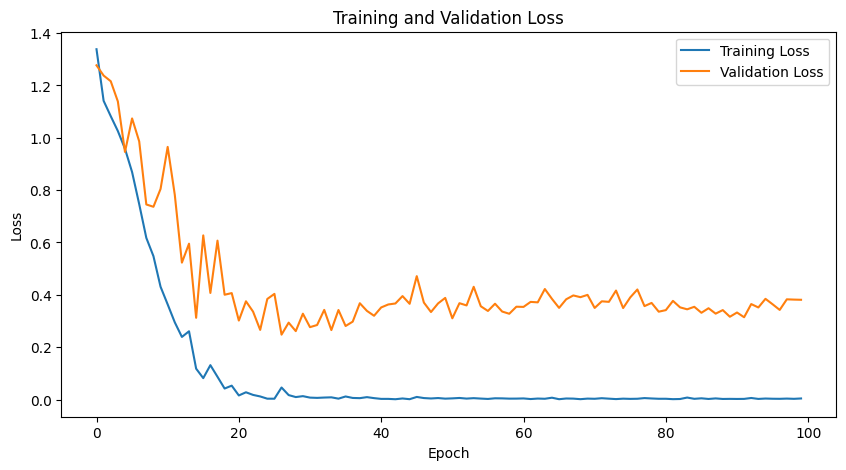

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

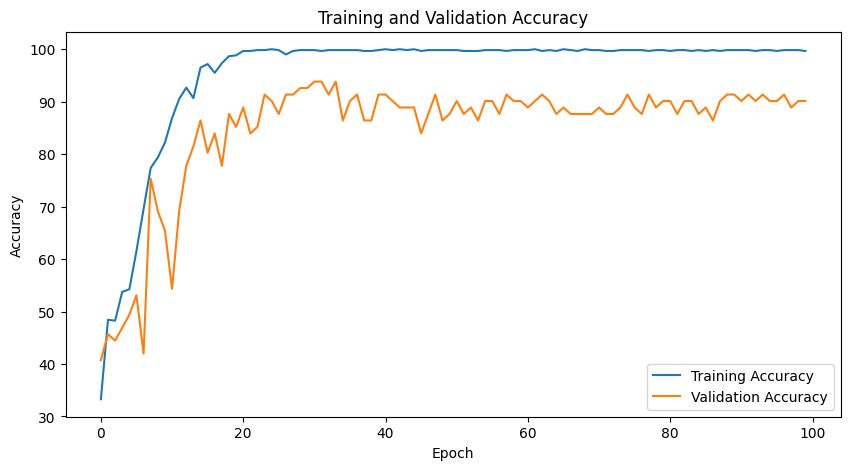

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:

# Hitung rata-rata metrik setelah semua epoch
average_train_loss = np.mean(train_losses)
average_valid_loss = np.mean(valid_losses)
average_train_accuracy = np.mean(train_accuracies)
average_valid_accuracy = np.mean(valid_accuracies)
average_train_precision = np.mean(train_precisions) # Calculate mean from stored values
average_valid_precision = np.mean(valid_precisions) # Calculate mean from stored values
average_train_recall = np.mean(train_recalls)     # Calculate mean from stored values
average_valid_recall = np.mean(valid_recalls)     # Calculate mean from stored values
average_train_f1 = np.mean(train_f1s)           # Calculate mean from stored values
average_valid_f1 = np.mean(valid_f1s)           # Calculate mean from stored values



# Display results training
print('--------------')
print(f'Training Accuracy: {average_train_accuracy:.2f}%')
print(f'Training Loss: {average_train_loss:.4f}')
print(f'Training Precision: {average_train_precision:.4f}')
print(f'Training Recall: {average_train_recall:.4f}')
print(f'Training F1-Score: {average_train_f1:.4f}')


# Display results validasi
print('--------------')
print(f'Validation Accuracy: {average_valid_accuracy:.2f}%')
print(f'Validation Loss: {average_valid_loss:.4f}')
print(f'Validation Precision: {average_valid_precision:.4f}')
print(f'Validation Recall: {average_valid_recall:.4f}')
print(f'Validation F1-Score: {average_valid_f1:.4f}')

--------------
Training Accuracy: 95.36%
Training Loss: 0.1089
Training Precision: 0.9548
Training Recall: 0.9536
Training F1-Score: 0.9507
--------------
Validation Accuracy: 84.70%
Validation Loss: 0.4403
Validation Precision: 0.8891
Validation Recall: 0.8470
Validation F1-Score: 0.8415


In [ ]:
def debug_pruned_weights(model):
    """
    Print out the number of filters and weights in each layer to ensure pruning is correctly applied.
    """
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            print(f"Layer: {name}, Weights Shape: {module.weight.shape}")

# Periksa model setelah pruning
debug_pruned_weights(pruned_model)


Layer: features.0, Weights Shape: torch.Size([45, 3, 3, 3])
Layer: features.2, Weights Shape: torch.Size([45, 45, 3, 3])
Layer: features.5, Weights Shape: torch.Size([90, 45, 3, 3])
Layer: features.7, Weights Shape: torch.Size([90, 90, 3, 3])
Layer: features.10, Weights Shape: torch.Size([180, 90, 3, 3])
Layer: features.12, Weights Shape: torch.Size([180, 180, 3, 3])
Layer: features.14, Weights Shape: torch.Size([180, 180, 3, 3])
Layer: features.17, Weights Shape: torch.Size([359, 180, 3, 3])
Layer: features.19, Weights Shape: torch.Size([359, 359, 3, 3])
Layer: features.21, Weights Shape: torch.Size([359, 359, 3, 3])
Layer: features.24, Weights Shape: torch.Size([359, 359, 3, 3])
Layer: features.26, Weights Shape: torch.Size([359, 359, 3, 3])
Layer: features.28, Weights Shape: torch.Size([359, 359, 3, 3])


In [ ]:
# Test the model

pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/fine_tuned_pruned_vgg-30.pth'))
pruned_model.eval()

# Start timer for testing
start_test_time = time.time()

test_loss = 0
all_test_preds = []
all_test_labels = []
correct = 0
total = 0
with torch.no_grad():
  for images, labels in tqdm(test_loader, desc='Testing'):
    images, labels = images.to(device), labels.to(device)

    # Convert grayscale images to 3 channels
    if images.size(1) == 1:
      images = images.repeat(1, 3, 1, 1)

    outputs = pruned_model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    all_test_preds.append(outputs)
    all_test_labels.append(labels)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy, test_precision, test_recall, test_f1 = calculate_metrics(torch.cat(all_test_preds), torch.cat(all_test_labels))
print("\n---------------------------------------------------------------------------------------------\n")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-Score: {test_f1:.4f}")

# End timer for testing and print the total time
end_test_time = time.time()
total_testing_time = end_test_time - start_test_time
print(f"Total Testing Time: {total_testing_time:.2f} seconds")

<ipython-input-27-915f0487c26a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/fine_tune


---------------------------------------------------------------------------------------------

Test Loss: 1.2648, Accuracy: 72.38%, Precision: 0.7746, Recall: 0.7238, F1-Score: 0.7071
Total Testing Time: 1.97 seconds


<ipython-input-28-ea43aeaade56>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/fine_tune

Total testing time: 1.44 seconds
Test Accuracy: 72.38%
Test Loss: 3.2385
Precision: 0.7746
Recall: 0.7238
F1-Score: 0.7071
Confusion Matrix:
[[98 18  1  3]
 [ 5 46  0  0]
 [ 3  0 51  0]
 [36 18  3 33]]


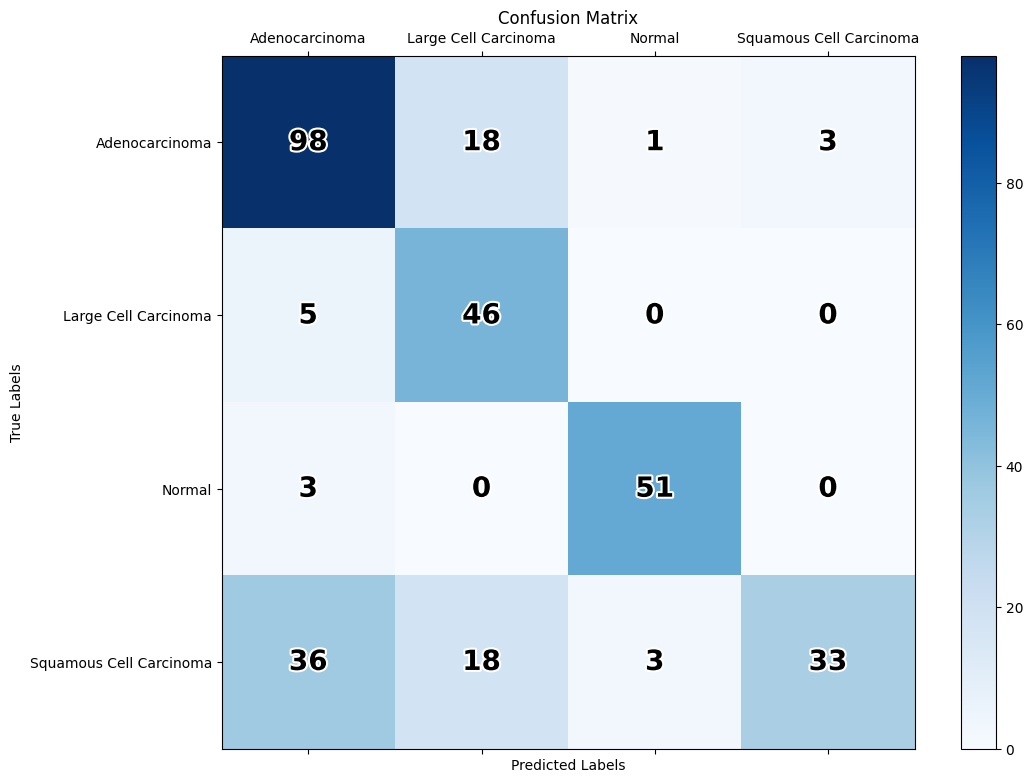

In [ ]:
# Path dinamis untuk memuat model terbaik
#best_model_file = '/content/drive/MyDrive/Chest-CT-Data/best-model-vgg-clahe-0,001.pth' if IN_COLAB else 'best-model.pth'
# Start testing time
testing_start_time = time.time()

# Load the best model
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Best-pruning-model/fine_tuned_pruned_vgg-30.pth'))
pruned_model.eval()

# Define class labels corresponding to the numerical labels
class_labels = [
    'Adenocarcinoma',
    'Large Cell Carcinoma',
    'Normal',
    'Squamous Cell Carcinoma'
]

predicted_probabilities = []
true_labels = []

test_loader_tqdm = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, labels in test_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        if images.dim() == 3:
            images = images.unsqueeze(1)
        images = images.repeat(1, 3, 1, 1)
        outputs = pruned_model(images)
        loss = criterion(outputs, labels)
        probabilities = nn.functional.softmax(outputs, dim=1)
        predicted_probabilities.append(probabilities)
        true_labels.append(labels)
        #test_loader_tqdm.set_postfix({"Batch Size": len(labels)})

# End testing time
total_testing_time = time.time() - testing_start_time
print(f"Total testing time: {total_testing_time:.2f} seconds")

# Calculate evaluation metrics
predicted_probabilities = torch.cat(predicted_probabilities)
true_labels = torch.cat(true_labels)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

accuracy = (predicted_labels == true_labels).float().mean().item()
precision = precision_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
recall = recall_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
f1 = f1_score(true_labels.cpu(), predicted_labels.cpu(), average='weighted')
conf_matrix = confusion_matrix(true_labels.cpu(), predicted_labels.cpu())

# Display results
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test Loss: {loss:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Plot confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(12, 9))
cax = ax.matshow(conf_matrix, cmap='Blues')

# Menampilkan angka pada setiap sel dengan outline putih
for (i, j), val in np.ndenumerate(conf_matrix):
    text = ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=20, fontweight='bold')

    # Menambahkan outline putih di sekitar angka
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),
                           path_effects.Normal()])

fig.colorbar(cax)

# Set ticks dan ticklabels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Total time for the whole process
#total_process_time = total_training_time + total_testing_time
#print(f"Total process time (training + testing): {total_process_time:.2f} seconds")


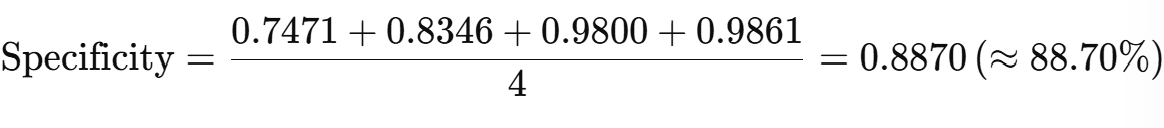